In [1]:
!pip install pandas natasha pymystem3 ipymarkup nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=af915240d9809928fa2b1d0cf854f39ead6ccf798a2b1e64eaa1f4ba32c7a780
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=88dafdc035440101b09f72424a61acf6d4de6803f7d2def11c8593f3878383e5
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built intervaltree docopt


In [2]:
import pandas as pd
import pymystem3
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.cluster import KMeans

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
from ipymarkup import show_dep_ascii_markup as show_markup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Работа с данными

Спаршенный сайт: [Lenta.ru](https://lenta.ru/)

Парсер: PR_NLP1-parser.py

In [7]:
# Загружаем данные
df = pd.read_csv('articles.csv', sep='\t')

# Удаляем лишние столбцы
morph_df = df.drop(["Unnamed: 0", "created_date"], axis=1)
morph_df

,title,content,category
0,В России начался весенний призыв. Сколько он п...,В России 1 апреля начался весенний призыв на в...,Россия
1,В России начался весенний призыв,В России 1 апреля начался весенний призыв на в...,Россия
2,Российские военные уничтожили место базировани...,Российские Воздушно-космические силы (ВКС) уни...,Мир
3,В России стало сложнее получить права после од...,"Нарушителей правил дорожного движения (ПДД), л...",Россия
4,В России с 1 апреля изменился экзамен на получ...,В России с 1 апреля изменился регламент экзаме...,Россия
...,...,...,...
295,Ряд поездов возобновили движение после обрушен...,Губернатор Смоленской области Василий Анохин з...,Путешествия
296,Убрать статью о дембеле и ограничить права укл...,Комитет Верховной Рады по обороне принял в пер...,Бывший СССР
297,Переспавшая с 500 партнерами порномодель назва...,"Порномодель из Австралии, которую называют «са...",Из жизни
298,Госкомиссия утвердила дату повторного запуска ...,Госкомиссия решила провести пуск первой ракеты...,Наука и техника


# Нормализация и векторизация данных

### Токенизация

In [8]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

#Хранилище токенов к каждому предложению
sent_tokens = []

for article in morph_df['content']:
    doc = Doc(article)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    doc.tag_morph(morph_tagger)
    for sentence in doc.sents: # получаем предложения
        # При принте синтаксиса вылетает ошибка "max() iterable argument is empty"
        #sentence.syntax.print()
        sent_tokens.append([])
        for token in sentence.tokens: # получаем токены
            print(token)
            sent_tokens[-1].append(token)



Выходные данные были обрезаны до нескольких последних строк (5000).
DocToken(start=567, stop=568, text='4', id='5_18', head_id='5_16', rel='nmod', pos='ADJ')
DocToken(start=569, stop=575, text='апреля', id='5_19', head_id='5_18', rel='flat', pos='NOUN', feats=<Inan,Gen,Masc,Sing>)
DocToken(start=575, stop=576, text=',', id='5_20', head_id='5_16', rel='punct', pos='PUNCT')
DocToken(start=577, stop=583, text='Зингер', id='5_21', head_id='5_23', rel='nsubj', pos='PROPN', feats=<Anim,Nom,Masc,Sing>)
DocToken(start=584, stop=589, text='снова', id='5_22', head_id='5_23', rel='advmod', pos='ADV', feats=<Pos>)
DocToken(start=590, stop=600, text='арестовали', id='5_23', head_id='5_6', rel='conj', pos='VERB', feats=<Perf,Ind,Plur,Past,Fin,Act>)
DocToken(start=600, stop=601, text='.', id='5_24', head_id='5_6', rel='punct', pos='PUNCT')
DocToken(start=602, stop=612, text='Выяснилось', id='6_1', head_id='6_0', rel='root', pos='VERB', feats=<Perf,Neut,Ind,Sing,Past,Fin,Mid>)
DocToken(start=612, stop

[[['призыв', 'начался'], ['который', None]], [['тысяч', 'сказано'], ['заместитель', None], ['Министерство', 'направлены'], ['он', 'заявил'], ['призыв', None]], [['призыв', 'связано'], [None, 'станет'], ['возраст', 'призывают'], [None, 'составлял']], [['Граждане', None], ['лет', None], ['призыву', None], ['возраст', 'приняли'], ['поправки', None], ['которые', None]], [['Повестки', 'могут']], [['система', 'считается'], [None, 'отлажена'], ['председатель', 'продолжится']], [[None, 'Фото'], ['повестка', 'подчеркнул']], [['Электронная', None], ['парламентарий', 'выросли'], ['размеры', 'могут'], ['штраф', 'могут']], [['которые', 'грозит'], ['взыскание', None], ['Призывников', None], ['которые', 'ожидает']], [['Потеря', 'обойдется'], [None, 'усилили'], [None, 'могут']], [['призыв', 'начался']], [['Кампания', 'сказано'], ['заместитель', 'завершится'], ['он', None], ['Представитель', 'заверил'], ['призыв', None]], [['вице-адмирал', 'связано'], ['это', 'сообщалось']], [['силы', 'уничтожили']], [

##

In [9]:
#Чистим датасет от ненужных данных

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])

STOP_LIST = nltk.corpus.stopwords.words('russian')

punkt_list = [".", ",", "!", "?", "...", ":", ";", "это", "слово", "который"
              "из", "на", "под", "ранее"]

lemma = []

mystem=pymystem3.Mystem()

for x in range(len(sent_tokens)):
    lemma.append([])
    for y in range(len(sent_tokens[x])):
        lemma[-1].append(mystem.lemmatize(sent_tokens[x][y].text))


for simb in punkt_list:
  STOP_LIST.append(simb)

lemma_words = {
    'word' : []
}

for sent in lemma:
  for word in sent:
    if word[0] not in STOP_LIST:
      #убираем числа
      try:
        if isinstance(int(word[0]), int):
          pass
      except ValueError:
          lemma_words['word'].append(word[0])

lemma_df = pd.DataFrame(lemma_words)

lemma_df

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,word
0,россия
1,апрель
2,начинаться
3,весенний
4,призыв
...,...
41581,принстонский
41582,университет
41583,использовать
41584,анализ


In [34]:
# Делаем датафрейм для последующей кластеризации

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lemma_df['word'])

word_pop_count = pd.DataFrame(X.toarray()).sum(axis = 0)

words = vectorizer.get_feature_names_out()

words_num = []
for word in words:
  insert_val = vectorizer.vocabulary_[word]
  words_num.append(insert_val)

df_pop_words = pd.DataFrame({'word': words,
                             'word_num': words_num,
                            'popularity': word_pop_count})



df_pop_words

,word,word_num,popularity
0,01,0,0.707107
1,23,1,0.707107
2,adom,2,1.000000
3,advances,3,1.000000
4,afp,4,1.000000
...,...,...,...
7736,ясень,7736,1.000000
7737,ясно,7737,2.000000
7738,ясный,7738,2.000000
7739,ясотхон,7739,1.000000


# Кластеризация

In [36]:
data = df_pop_words[['word_num', 'popularity']]

kmeans = KMeans(n_clusters=4)

kmeans.fit(data)

cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Визуализация кластеров

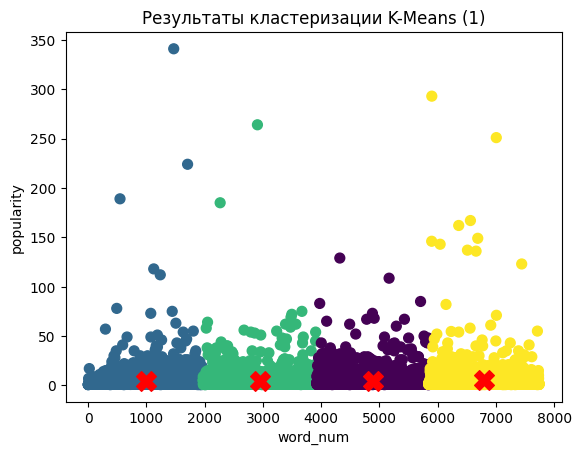

In [37]:
plt.scatter(df_pop_words['word_num'], df_pop_words['popularity'], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel('word_num')
plt.ylabel('popularity')
plt.title('Результаты кластеризации K-Means (1)')
plt.show()

In [44]:
# Добавляем индексы кластеров к нашем датафрейму

df_pop_words['cluster'] = list(kmeans.labels_)

df_pop_words

,word,word_num,popularity,cluster
0,01,0,0.707107,1
1,23,1,0.707107,1
2,adom,2,1.000000,1
3,advances,3,1.000000,1
4,afp,4,1.000000,1
...,...,...,...,...
7736,ясень,7736,1.000000,3
7737,ясно,7737,2.000000,3
7738,ясный,7738,2.000000,3
7739,ясотхон,7739,1.000000,3


In [45]:
#Значения кластера 1

df_pop_words[df_pop_words['cluster'] == 1]

,word,word_num,popularity,cluster
0,01,0,0.707107,1
1,23,1,0.707107,1
2,adom,2,1.000000,1
3,advances,3,1.000000,1
4,afp,4,1.000000,1
...,...,...,...,...
1968,единица,1968,10.000000,1
1969,единичный,1969,1.000000,1
1970,единоборство,1970,1.000000,1
1971,единогласно,1971,1.000000,1


В данном кластере находятся все числовые значения, которые смогли пройти фильтрацию, а также все англоязычные термины и слова русского языка от А до Е

In [46]:
# кластер 2

df_pop_words[df_pop_words['cluster'] == 2]

,word,word_num,popularity,cluster
1973,единственный,1973,5.0,2
1974,единство,1974,5.0,2
1975,единый,1975,9.0,2
1976,еж,1976,1.0,2
1977,ежегодно,1977,7.0,2
...,...,...,...,...
3918,нормально,3918,1.0,2
3919,нормальный,3919,2.0,2
3920,нормировать,3920,1.0,2
3921,носик,3921,1.0,2


В данном кластере находятся слова русского языка от Е до Н

In [47]:
# кластер 3

df_pop_words[df_pop_words['cluster'] == 3]

,word,word_num,popularity,cluster
5843,рисование,5843,1.0,3
5844,ритм,5844,2.0,3
5845,риторика,5845,2.0,3
5846,ритуальный,5846,1.0,3
5847,риш,5847,2.0,3
...,...,...,...,...
7736,ясень,7736,1.0,3
7737,ясно,7737,2.0,3
7738,ясный,7738,2.0,3
7739,ясотхон,7739,1.0,3


В данном кластере находятся слова русского языка от Р до Я

In [49]:
#кластер 4

df_pop_words[df_pop_words['cluster'] == 0]

,word,word_num,popularity,cluster
3923,носить,3923,2.000000,0
3924,носов,3924,3.000000,0
3925,нота,3925,3.000000,0
3926,ночной,3926,1.000000,0
3927,ночь,3927,9.000000,0
...,...,...,...,...
5838,римский,5838,4.000000,0
5839,рио,5839,0.601638,0
5840,риск,5840,12.000000,0
5841,рискованно,5841,1.000000,0


В данном кластере расположены слова русского языка от Н до Р